# Histopathologic Cancer Detection

This project is part of the course Introduction to Deep Learning from the University of Colorado Boulder and includes a participation in the <a href="https://www.kaggle.com/competitions/histopathologic-cancer-detection/code">Histopathologic Cancer Detection</a> competition of Kaggle.


### Imports and setup

In [1]:
import numpy as np 
import pandas as pd 
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    roc_curve,
    ConfusionMatrixDisplay
)

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
train_labels = pd.read_csv('../data/train_labels.csv')
test_dir = '../data/test/'
train_dir = '../data/train/'
train_jpeg_dir = '../data/train_jpeg/'
test_jpeg_dir = '../data/test_jpeg/'


<IPython.core.display.Javascript object>

### EDA

The purpose of the competition is to develop a model that can "Identify metastatic tissue in histopathologic scans of lymph node sections" accurately and more efficiently than the regular detection method that requires time of an expecialist. In order to do this task, there is a dataset of around 220,000 labeled images and 50,000 unlabelled.

In [4]:
print(f'The number of labelled images is {len(train_labels)} from which { train_labels["label"].sum() } are classified as cancerous')

The number of labelled images is 220025 from which 89117 are classified as cancerous


<IPython.core.display.Javascript object>

As we can see the dataset is pretty balanced and does not require resampling. Let's see some of the images.

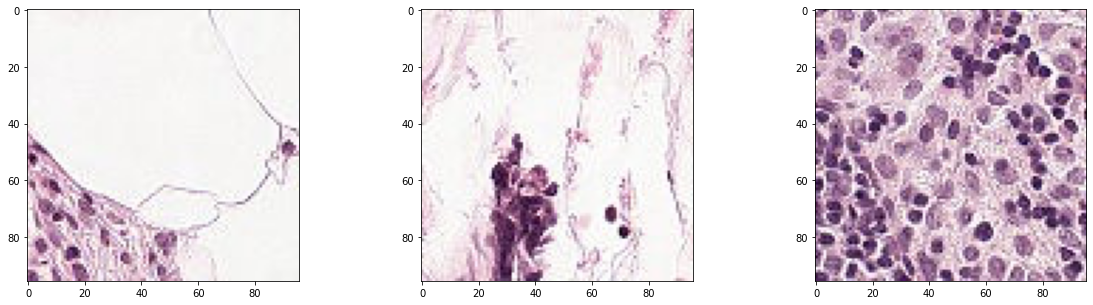

<IPython.core.display.Javascript object>

In [5]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(Image.open(train_dir+train_labels.loc[0,'id']+'.tif'))
axs[1].imshow(Image.open(train_dir+train_labels.loc[1,'id']+'.tif'))
axs[2].imshow(Image.open(train_dir+train_labels.loc[2,'id']+'.tif'))
fig.set_size_inches(20,5)

Unfortunately I am clueless about cancer detection and don't have an expert available that can help me with this project, so I am going to trust the labels, and focus on the modelling.

### Data Engineering

For the model I plan to use a Keras model and the image_dateset_from_directory function to create a tensorflow dataset. This function requieres a format different from .tif and the label should be included in the picture address. The next two cells transform the competitions data into a format compatible with the image_dataset_from_directory function

In [6]:
# # Train data
# ### ONLY RUN ONCE
# for file in os.listdir(train_dir):
#     file_pref = file[:-4]
#     outfile = file[:-3] + "jpeg"
#     im = Image.open(train_dir + file)
#     out = im.convert("RGB")
#     out.save(train_jpeg_dir + str(train_labels.set_index('id').loc[file_pref,'label']) + '/' + outfile, "JPEG") 

<IPython.core.display.Javascript object>

In [7]:
# # Test data
# ### ONLY RUN ONCE
# for file in os.listdir(test_dir):
#     file_pref = file[:-4]
#     outfile = file[:-3] + "jpeg"
#     im = Image.open(test_dir + file)
#     out = im.convert("RGB")
#     out.save(test_jpeg_dir + outfile, "JPEG") 

<IPython.core.display.Javascript object>

Now let's create the train, validation and test tensorflow datasets.

In [8]:
train_dataset = image_dataset_from_directory(
    train_jpeg_dir,
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(96,96),
    batch_size=1000
    
)
validation_dataset = image_dataset_from_directory(
    train_jpeg_dir,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(96,96),
    batch_size=1000,
)
test_dataset = image_dataset_from_directory(
    test_jpeg_dir,
    label_mode=None,
    image_size=(96,96),
    batch_size=1000,
    shuffle=False,
)

Found 220025 files belonging to 2 classes.
Using 198023 files for training.


2022-07-26 18:30:36.319178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-26 18:30:36.319294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Found 220025 files belonging to 2 classes.
Using 22002 files for validation.
Found 57458 files belonging to 1 classes.


<IPython.core.display.Javascript object>

## Modelling

We are now ready to fit a model into the data. For this particular problem we are working with images, so a convolutional neural network will be fitted. The Keras module from Tensorflow was the framework selected for its ease of use and because I have some experience with this particular library.<br>
For model fitting the loss and optimizer selected were binary crossentropy and adam, and multiple architechtures were tested including one that relied on the xception model as a preprocessing step. The hyperparameter tunning was not exhaustive and could be improved, but it was enough to find a model with good predictive power. The resulting model is composed of 4 convolutional blocks and two adional dense layers where each block is formed by a batch normalization layer followed by a convolutional layer, a dropout layer and a final average pooling layer. The details of the model can be found in the following code cells.

In [9]:
inputs = keras.layers.Input([96,96,3], dtype = tf.float32)
#x = keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(96,96,3))(inputs)
x = keras.layers.Rescaling(scale=1./255)(inputs)#(x)
# B1
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(15,3,activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# B2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(20,3,activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# B3
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(50,3,activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# B4
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(80,5,strides=(5,5),activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# Dense
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(25,activation='relu')(x)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [10]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

<IPython.core.display.Javascript object>

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 15)        420       
                                                                 
 dropout (Dropout)           (None, 94, 94, 15)        0         
                                                                 
 average_pooling2d (AverageP  (None, 47, 47, 15)       0         
 ooling2D)                                                   

<IPython.core.display.Javascript object>

Tow callbacks were included into the model fitting, a early stopping so that training is halted when the validation loss stops improving, and a model checkpoint callback which saves the best models.

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('../data/model_cp_1', save_best_only=True, monitor='val_loss', verbose=False)

<IPython.core.display.Javascript object>

Model fitting

In [23]:

fit_history = model.fit(train_dataset, epochs=1000, validation_data=validation_dataset, callbacks=[early_stopping, model_checkpoint])
fit_history_2 = model.fit(train_dataset, epochs=1000, validation_data=validation_dataset, callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
199/199 [==============================] - 58s 290ms/step - loss: 0.1617 - binary_accuracy: 0.9359 - val_loss: 0.2074 - val_binary_accuracy: 0.9220
Epoch 2/1000
199/199 [==============================] - 57s 287ms/step - loss: 0.1605 - binary_accuracy: 0.9370 - val_loss: 0.1846 - val_binary_accuracy: 0.9297
Epoch 3/1000
199/199 [==============================] - 58s 289ms/step - loss: 0.1599 - binary_accuracy: 0.9374 - val_loss: 0.1888 - val_binary_accuracy: 0.9284
Epoch 4/1000
199/199 [==============================] - 58s 288ms/step - loss: 0.1579 - binary_accuracy: 0.9382 - val_loss: 0.1866 - val_binary_accuracy: 0.9299
Epoch 5/1000
199/199 [==============================] - 57s 287ms/step - loss: 0.1577 - binary_accuracy: 0.9384 - val_loss: 0.2286 - val_binary_accuracy: 0.9182
Epoch 6/1000
199/199 [==============================] - 58s 289ms/step - loss: 0.1593 - binary_accuracy: 0.9380 - val_loss: 0.1763 - val_binary_accuracy: 0.9343
Epoch 7/1000
199/199 [============

### Model exploration

The following plots show the evolution of the training and validation lossses and accuracies as the fitting took place. These plots shows that the model has no significant overfitting and good predictive power.

(0.0, 0.5)

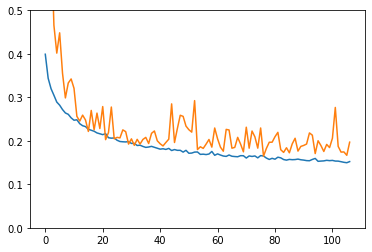

<IPython.core.display.Javascript object>

In [22]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'] )
ax = plt.gca()
ax.set_ylim(0,0.5)



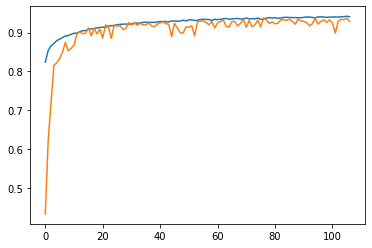

<IPython.core.display.Javascript object>

In [15]:

plt.plot(fit_history.history['binary_accuracy'])
plt.plot(fit_history.history['val_binary_accuracy'] )

In [15]:
# model.save('../data/model_cp_1')
# model = keras.models.load_model('../data/model_cp_1')

<IPython.core.display.Javascript object>

In order to further evaluate the model let's look at the validation ROC AUC and confussion matrix.

In [10]:
probas = np.array([])
labels =  np.array([])
for x, y in validation_dataset:
    probas = np.concatenate([probas, model.predict(x, verbose=False).reshape(-1)])
    labels = np.concatenate([labels, y])
results_validation = pd.DataFrame(
    columns = ['proba','label'],
    data = zip(probas,labels)
)
results_validation['prediction'] = results_validation['proba'].apply(lambda x: int(x>0.5))

2022-07-26 18:30:47.656907: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-26 18:30:48.186770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<IPython.core.display.Javascript object>

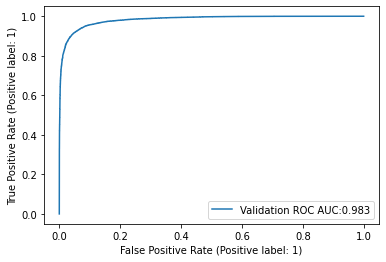

<IPython.core.display.Javascript object>

In [12]:
RocCurveDisplay.from_predictions(
    results_validation['label'],
    results_validation['proba'],
    label=f"Validation ROC AUC:{round(roc_auc_score(results_validation['label'], results_validation['proba']),3)}",
)

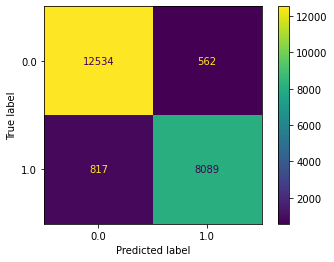

<IPython.core.display.Javascript object>

In [13]:
ConfusionMatrixDisplay.from_predictions(
    results_validation['label'],
    results_validation['prediction']
)

The confussion matrix shows that the model does a very good job at identifying cancerous images, but still has a lot to improve. Considering the importance of being accurate in this kind of tests, the model is not good enough to replace the medical expert, but still may be used as a prioritization guide.

### Kaggle submission

In [20]:
test_predict = model.predict(test_dataset)
results_test = pd.DataFrame(
    columns = ['id','label'],
    data = zip([x.split('/')[3].split('.')[0] for x in test_dataset.file_paths],test_predict.reshape(-1))
)

58/58 [==============================] - 4s 70ms/step


<IPython.core.display.Javascript object>

In [21]:
results_test.to_csv('../data/submission_kaggle.csv',index=False)

<IPython.core.display.Javascript object>

### Conclusion

Using keras we were able to create a CNN with good capabilities for identifying cancer in histopathologic scans. This model can be improved considerably byextending the hyperparameter tunning, including an expert's opinion in the modelling process and by using data augmentation techniques.